In [1]:
from helpers_processing import json_to_csv, unique_display_link, remove_most_popular, expand_labels, unique_display_link_prediction, labeling
from helpers_classification import data_preparation, training, compute_nb_errors, predict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, argmax
import torch
sns.set_style("white")

## Processing Pipeline

In [3]:
json_to_csv('../data/google.json', '../data/data_processed.csv')

unique_display_link('../data/data_processed.csv', '../data/unique_displayLink.csv')

remove_most_popular('../data/unique_displayLink.csv', '../data/drug_websites_filtered.csv','../data/top-1m.csv')

expand_labels('../data/labelled_unique.csv', '../data/data_processed.csv', '../data/labelled_expanded.csv')

## Exploration

In [2]:
df = pd.read_csv('../data/labelled_expanded.csv', index_col='link')

In [31]:
print("""There are a total of {} links listed of which {} are labelled. {} labelled are not webshops, {} are webshops and {} are dead links.""".format(len(df), 
                                                           len(df[~df['label'].isnull()]),\
                                                           len(df[df['label'] == 0.0]),\
                                                           len(df[df['label'] == 1.0]),\
                                                           len(df[df['label'] == 2.0])))

There are a total of 510192 links listed of which 197299 are labelled. 121980 labelled are not webshops, 37606 are webshops and 37713 are dead links.


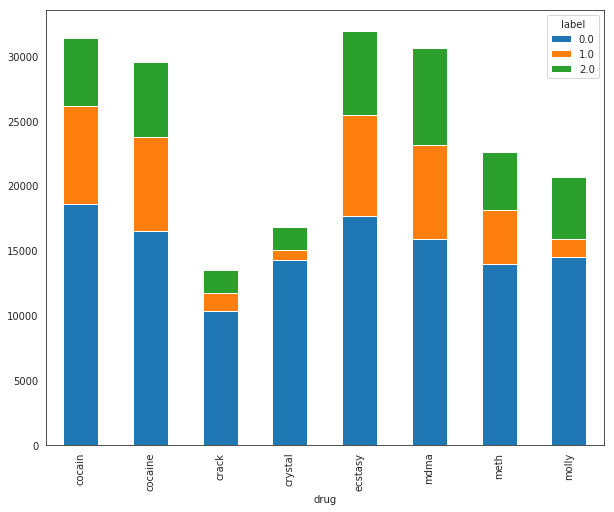

In [4]:
df.groupby(['drug','label']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,8));
plt.savefig('../figures/drug_distribution.eps',format='eps')

From the above plot we can see that for the words 'crack', 'crystal' and 'molly there are many false positives and little true positives.

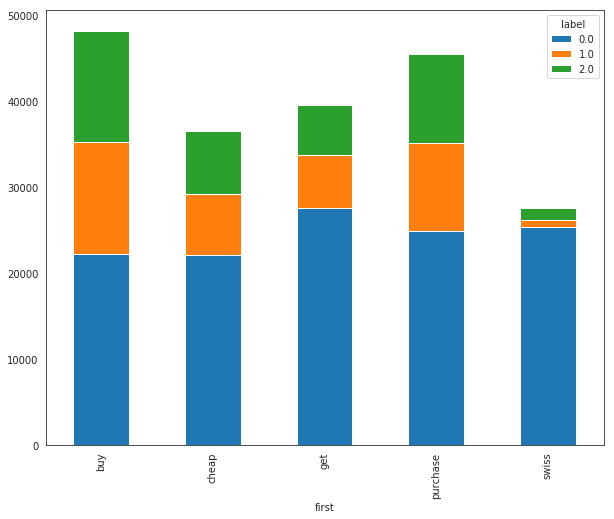

In [5]:
df.groupby(['first','label']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,8));
plt.savefig('../figures/first_distribution.eps',format='eps')

We can see that the word 'swiss' has almost no true positives.

## Classification Pipeline

In [6]:
x_train,y_train,x_test,y_test,unlabelled_data,unlabelled = data_preparation('../data/labelled_expanded.csv')

In [7]:
model = nn.Sequential(
        nn.Linear(10000, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(32,2))

In [8]:
training(model, x_train, y_train)

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


In [9]:
print(compute_nb_errors(model, x_train, y_train) / x_train.size(0) * 100)
print(compute_nb_errors(model, x_test, y_test) / x_test.size(0) * 100)

0.0660377358490566
0.12264150943396226


In [10]:
torch.save(model, '../models/mlp.pt')

In [11]:
model = torch.load('../models/mlp.pt')

In [12]:
predict(unlabelled_data, unlabelled, model, '../data/labelled_prediction_expanded.csv')

In [13]:
unique_display_link_prediction('../data/labelled_prediction_expanded.csv',
                               '../data/labelled_prediction_unique.csv')

In [14]:
df = pd.read_csv('../data/labelled_prediction_unique.csv', index_col='displayLink')

## Exploring the predictions

In [21]:
df[df['label']==1].head(20)

,text,first,drug,count,label,ratio,label_count
displayLink,,,,,,,
www.nacsupply.com,Asphalt Supplies - Sealcoat Supply - Sealcoati...,purchase,crack,116,1,1.0,116
darlabulkmeds.com,Buy Pure Cocaine online - USA - CANADA - UK -R...,purchase,cocaine,102,1,1.0,102
www.researchchemicalsforsale.com,Buy cocaine online From us today and have a sa...,purchase,cocaine,102,1,1.0,102
nembutalman.blogspot.com,"buy cheap nembutal, dexedrine, amphetamine, me...",cheap,meth,101,1,1.0,101
www.medicalmarijuanasupliez.com,Buy crack cocaine for sale | buy powder cocain...,purchase,cocaine,100,1,1.0,100
buycokeonline.com,buy crack online | Buy Coke Online | Bitcoins ...,buy,crack,99,1,1.0,99
ukadss.co.uk,Purchase Pure cocaine online-(Whatsapp:+237-65...,purchase,cocaine,99,1,1.0,99
researchchemicalintermediates.wholesale.wneducation.com,"Research Chemicals BK MDMA, Research Chemicals...",cheap,mdma,98,1,1.0,98
www.chemistryorg.com,"Now, let's take one research chemical as an ex...",purchase,mdma,95,1,1.0,95


In [24]:
df[df['label']==0].tail(20)

,text,first,drug,count,label,ratio,label_count
displayLink,,,,,,,
www.tesco.ie,Products 41 - 60 of 97 ... Our online supermar...,swiss,molly,4,0,0.0,0
www.frommers.com,"Exploring Alps near Lucerne: Pilatus, Rigi, an...",swiss,molly,10,0,0.0,0
www.cbre.ch,"Properties, services, research and more from t...",swiss,molly,3,0,0.0,0
www.swisscottagedance.com,http://www.freedoflondon.com/Web/Site/Product/...,swiss,molly,8,0,0.0,0
www.dakine.ch,"... bike, windsurf and kite. Nouvelles de la s...",swiss,molly,3,0,0.0,0
www.molliekatzen.com,Roasted Red Peppers Marinated with Garlic and ...,swiss,molly,63,0,0.0,0
www.jodyrobbins.com,"Feb 25, 2015 ... Did you know winter tourism o...",swiss,molly,8,0,0.0,0
blogs.ancestry.com,"Apr 24, 2016 ... Recap Featuring Molly Ringwal...",swiss,molly,28,0,0.0,0
www.swiss-web.com,8. Okt. 2015 ... SwissWeb bietet ohne Unterbre...,swiss,molly,51,0,0.0,0
